2. Evaluating the accuracy of text localization in the image for each word

In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import os
from PIL import Image
import time

In [2]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

OperationStatusCodes.running
OperationStatusCodes.succeeded
Lucces          | IoU: 0.73
in              | IoU: 0.65
resolvarea      | IoU: 0.85
TEMELOR         | IoU: 0.82
la              | IoU: 0.67
LABORA          | IoU: 0.47
toarele         | IoU: 0.43
de              | IoU: 0.78
Inteligenta     | IoU: 0.61
Artificialà!    | IoU: 0.59


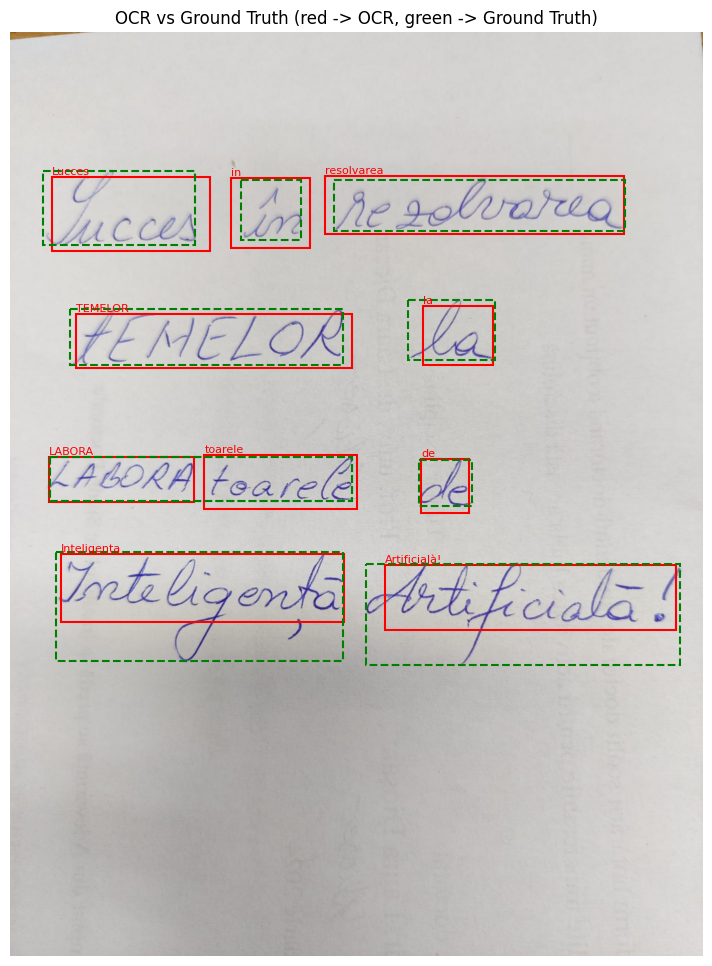

In [29]:
from matplotlib import pyplot as plt, patches

img = open("data/images/test2.jpeg", "rb")
read_response = computervision_client.read_in_stream(
    image=img,
    mode="Printed",
    raw=True
)
operation_id = read_response.headers['Operation-Location'].split('/')[-1]
while True:
    read_result = computervision_client.get_read_result(operation_id)
    print(read_result.status)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

# Real x1,y1,x2,y2 for every word
ground_truth_boxes = [
    (70, 300, 400, 460),
    (500, 320, 630, 450),
    (700, 320, 1330, 430),
    (130, 600, 720, 720),
    (860, 580, 1050, 710),
    (85, 920, 740, 1015),
    (885, 925, 1000, 1025),
    (100, 1125, 720, 1360),
    (770, 1150, 1450, 1370)
]

def compute_iou(box_a, box_b):
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[0] + box_a[2], box_b[0] + box_b[2])
    y_b = min(box_a[1] + box_a[3], box_b[1] + box_b[3])

    intersection_area = max(0, x_b - x_a) * max(0, y_b - y_a)
    box_a_area = box_a[2] * box_a[3]
    box_b_area = box_b[2] * box_b[3]
    iou = intersection_area / float(box_a_area + box_b_area - intersection_area)
    return iou

image = Image.open(img)
plt.figure(figsize=(10, 12))
plt.imshow(image)
ax = plt.gca()

i=0
if read_result.status == OperationStatusCodes.succeeded:
    for page in read_result.analyze_result.read_results:
        for line in page.lines:
            for word in line.words:

                x1, y1 = word.bounding_box[0], word.bounding_box[1]
                x2, y2 = word.bounding_box[4], word.bounding_box[5]
                width = x2 - x1
                height = y2 - y1

                # Red OCR resulted boxes
                rect = patches.Rectangle((x1, y1), width, height, linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x1, y1 - 5, word.text, fontsize=8, color='red')


                gt = ground_truth_boxes[i]
                iou = compute_iou([x1, y1, width, height], [gt[0], gt[1], gt[2]-gt[0], gt[3]-gt[1]])
                print(f"{word.text:15} | IoU: {iou:.2f}")

                # Check if a word was divided in n words
                if gt[2]-x2 > 150:
                    i-= 1

                # Green ground truth boxes
                rect_gt = patches.Rectangle((gt[0], gt[1]), gt[2]-gt[0], gt[3]-gt[1], linewidth=1.5, edgecolor='g', facecolor='none', linestyle='--')
                ax.add_patch(rect_gt)
                i+=1

plt.axis('off')
plt.title("OCR vs Ground Truth (red -> OCR, green -> Ground Truth)")
plt.show()